In [1]:
%matplotlib inline

In [ ]:
from Bio import SeqIO
import pandas as pd

# Double checking sequence extraction

In [ ]:
taxa = 287
tsv_loc = '../Data/host_genomes/{}.clean.tsv'.format(taxa)
df = pd.read_csv(tsv_loc, sep = "\t", index_col = 0)

fasta_loc = '../Data/host_genomes/{}.fasta'.format(taxa)
genome_seq = SeqIO.read(fasta_loc, 'fasta')

gff3_loc = '../Data/host_genomes/{}.gff3'.format(taxa)
gff3_df = pd.read_csv(gff3_loc, sep='\t', comment='#', header=None)

In [ ]:
seq_dicty = {}
gff3_df = gff3_df[gff3_df[2]=='CDS']

for index in gff3_df.index:
    if gff3_df.at[index, 6] == '+':
        start = gff3_df.at[index, 3]
        locus_tag = gff3_df.at[index, 8].split(';Parent=gene-')[1].split(';')[0]
        seq_dicty[locus_tag] = genome_seq.seq[start-31:start+29]
for index in df.index:
    if df.at[index, 'strand'] == '+':
        assert df.at[index, 'upstream_sequence']+df.at[index, 'coding_sequence'][:30] ==\
                seq_dicty[df.at[index, 'locus_tag']]

In [ ]:
seq_dicty = {}
gff3_df = gff3_df[gff3_df[2]=='CDS']

for index in gff3_df.index:
    if gff3_df.at[index, 6] == '-':
        start = gff3_df.at[index, 4]
        locus_tag = gff3_df.at[index, 8].split(';Parent=gene-')[1].split(';')[0]
        seq_dicty[locus_tag] = genome_seq.seq[start-30:start+30].reverse_complement()
for index in df.index:
    if df.at[index, 'strand'] == '-':
        assert df.at[index, 'upstream_sequence']+df.at[index, 'coding_sequence'][:30] ==\
                seq_dicty[df.at[index, 'locus_tag']]

# And a little null analysis on the *expected* relationship between secondary structure and aSD binding energy

In [15]:
import json
import numpy as np

import statsmodels.formula.api as smf

In [10]:
gaps=(4,10)
RBS_len=6
with open('../Data/energy_files/energyRef_CCUCCU_ensemble_noneConstraint.json', 'r') as infile:
       energy_dict = json.load(infile)
        
ec_df = pd.read_csv('../Data/562_associated_data/ecoli.combined.tsv', sep='\t', index_col=0)
ec_df_indices = list(ec_df.index)

In [11]:
total_nts = ec_df['upstream_sequence'].str.len().sum()
for nt in ['A', 'T', 'G', 'C']:
    print(nt, ec_df['upstream_sequence'].str.count(nt).sum()/total_nts)

A 0.3184646962233169
T 0.25085385878489325
G 0.24104269293924466
C 0.18963875205254516


**This takes a little while so I only am running once (thus commenting to prevent screwing it up) and saving the file and reading it back in later**

In [94]:
# ss_list = []
# rbs_list = []
# for i in range(200000):
# #     utr_str = ''.join(np.random.choice(['A', 'U', 'G', 'C'], p=[0.25, 0.25, 0.25, 0.25], size=30))
#     utr_str = ''.join(np.random.choice(['A', 'U', 'G', 'C'], p=[0.3185, 0.2509, 0.2410, 0.1896], size=30))
#     cds_seq = ec_df.iloc[np.random.choice(ec_df_indices)]['coding_sequence']
#     if len(cds_seq) > 30:
#         combined = utr_str + cds_seq[:30]
#         assert len(combined) == 60
#         rna_out = call_RNAfold(combined)
#         e1, e2 = get_energy_RNAfold(rna_out)
#         ss_list.append(e2)
        
#         ###Calculate the energy for the indicated gap offsets
#         energy_list = []
#         for gap in range(gaps[0],gaps[1]+1):
#              energy_list.append(energy_dict[utr_str[-gap - RBS_len: -gap]])

#         rbs_list.append(min(energy_list))
        
        
# random_df = pd.DataFrame(zip(ss_list, rbs_list), columns=['secondary_structure', 'RBS_energy'])
# print(random_df.shape)
# random_df.to_csv('../Data/562_associated_data/randomdata.tsv', sep='\t')

In [105]:
random_df = pd.read_csv('../Data/562_associated_data/randomdata.tsv', sep='\t', index_col=0)
print(random_df.shape)
random_df.head()

(200000, 2)


,secondary_structure,RBS_energy
0,-13.36,-0.56
1,-15.99,-0.55
2,-12.12,-3.54
3,-4.07,-0.01
4,-10.99,-2.50


In [109]:
assert len(list(ec_df['genome_id'].value_counts().keys())) == 1
host_name = ec_df['genome_id'].value_counts().keys()[0]
#
concat_df = pd.concat((ec_df, random_df), ignore_index=True, sort=False)
concat_df['binary_predictor'] = 1
concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0
print(concat_df.shape)

concat_df['RBS_energy'] += 9.51

(204060, 26)


In [162]:
###Fixed intercept effect
fitted = smf.ols('secondary_structure ~ RBS_energy + I(binary_predictor)', data=concat_df).fit(disp=0)

###Random intercept 
# fitted = smf.mixedlm('secondary_structure ~ RBS_energy',\
#                  data=concat_df, groups=concat_df['binary_predictor']).fit(disp=0)

###Random slope
# fitted = smf.mixedlm('secondary_structure ~ RBS_energy',\
#                  data=concat_df, re_formula='0+RBS_energy', groups=concat_df['binary_predictor']).fit(disp=0)

###Random intercept and random slope
# fitted = smf.mixedlm('secondary_structure ~ RBS_energy',\
#                  data=concat_df, re_formula='RBS_energy', groups=concat_df['binary_predictor']).fit(disp=0)

print(fitted.summary())



                             OLS Regression Results                            
Dep. Variable:     secondary_structure   R-squared:                       0.028
Model:                             OLS   Adj. R-squared:                  0.028
Method:                  Least Squares   F-statistic:                     2908.
Date:                 Tue, 10 Mar 2020   Prob (F-statistic):               0.00
Time:                         12:30:35   Log-Likelihood:            -5.4169e+05
No. Observations:               204060   AIC:                         1.083e+06
Df Residuals:                   204057   BIC:                         1.083e+06
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -1

**Parsimoniously grabbing similar values**

In [166]:
random_indices = []
for index in ec_df.index[:]:
    rbs = ec_df.loc[index]['RBS_energy']
    temp_df = random_df[random_df['RBS_energy'] == rbs]
    if temp_df.shape[0]>0:
        choice = np.random.choice(temp_df.index)
        random_indices.append(choice)

In [167]:
temp_df = random_df.loc[random_indices]
concat_df = pd.concat((ec_df, temp_df), ignore_index=True, sort=False)
concat_df['binary_predictor'] = 1
concat_df.at[concat_df[concat_df['genome_id'] == host_name].index, 'binary_predictor'] = 0
print(concat_df.shape)

(8120, 26)


In [168]:
fitted = smf.ols('secondary_structure ~ RBS_energy',\
                 data=ec_df).fit(disp=0)
print(fitted.summary())

fitted = smf.ols('secondary_structure ~ RBS_energy',\
                 data=temp_df).fit(disp=0)
print(fitted.summary())

                             OLS Regression Results                            
Dep. Variable:     secondary_structure   R-squared:                       0.072
Model:                             OLS   Adj. R-squared:                  0.072
Method:                  Least Squares   F-statistic:                     314.7
Date:                 Tue, 10 Mar 2020   Prob (F-statistic):           7.04e-68
Time:                         12:32:28   Log-Likelihood:                -10833.
No. Observations:                 4060   AIC:                         2.167e+04
Df Residuals:                     4058   BIC:                         2.168e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.7048      0.129    -59.55

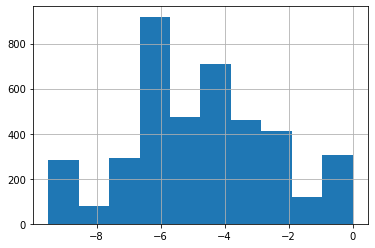

In [169]:
temp_df['RBS_energy'].hist()

In [ ]:
from scipy import stats
print(stats.spearmanr(rbs_list, ss_list), '\n\n', stats.linregress(rbs_list, ss_list))

In [ ]:
stats.linregress(old['RBS_energy'], old['secondary_structure'])

In [ ]:
print(old['secondary_structure'].mean(), np.mean(ss_list),\
      stats.ttest_ind(old['secondary_structure'], ss_list))
print()
print(old['RBS_energy'].mean(), np.mean(rbs_list),\
      stats.ttest_ind(old['RBS_energy'], rbs_list))

In [ ]:
(0.3111*-9.51) + -9.91

In [ ]:
(0.436*-9.51) + -7.7